In [1]:
%matplotlib inline


# SVG Tooltip


This example shows how to create a tooltip that will show up when
hovering over a matplotlib patch.

Although it is possible to create the tooltip from CSS or javascript,
here we create it in matplotlib and simply toggle its visibility on
when hovering over the patch. This approach provides total control over
the tooltip placement and appearance, at the expense of more code up
front.

The alternative approach would be to put the tooltip content in ``title``
attributes of SVG objects. Then, using an existing js/CSS library, it
would be relatively straightforward to create the tooltip in the
browser. The content would be dictated by the ``title`` attribute, and
the appearance by the CSS.


:author: David Huard


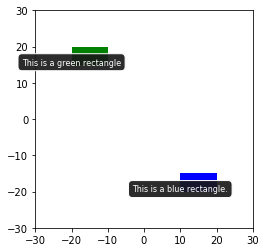

In [2]:
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from io import BytesIO

ET.register_namespace("", "http://www.w3.org/2000/svg")

fig, ax = plt.subplots()

# Create patches to which tooltips will be assigned.
rect1 = plt.Rectangle((10, -20), 10, 5, fc='blue')
rect2 = plt.Rectangle((-20, 15), 10, 5, fc='green')

shapes = [rect1, rect2]
labels = ['This is a blue rectangle.', 'This is a green rectangle']

for i, (item, label) in enumerate(zip(shapes, labels)):
    patch = ax.add_patch(item)
    annotate = ax.annotate(labels[i], xy=item.get_xy(), xytext=(0, 0),
                           textcoords='offset points', color='w', ha='center',
                           fontsize=8, bbox=dict(boxstyle='round, pad=.5',
                                                 fc=(.1, .1, .1, .92),
                                                 ec=(1., 1., 1.), lw=1,
                                                 zorder=1))

    ax.add_patch(patch)
    patch.set_gid('mypatch_{:03d}'.format(i))
    annotate.set_gid('mytooltip_{:03d}'.format(i))

# Save the figure in a fake file object
ax.set_xlim(-30, 30)
ax.set_ylim(-30, 30)
ax.set_aspect('equal')

f = BytesIO()
plt.savefig(f, format="svg")

# --- Add interactivity ---

# Create XML tree from the SVG file.
tree, xmlid = ET.XMLID(f.getvalue())
tree.set('onload', 'init(event)')

for i in shapes:
    # Get the index of the shape
    index = shapes.index(i)
    # Hide the tooltips
    tooltip = xmlid['mytooltip_{:03d}'.format(index)]
    tooltip.set('visibility', 'hidden')
    # Assign onmouseover and onmouseout callbacks to patches.
    mypatch = xmlid['mypatch_{:03d}'.format(index)]
    mypatch.set('onmouseover', "ShowTooltip(this)")
    mypatch.set('onmouseout', "HideTooltip(this)")

# This is the script defining the ShowTooltip and HideTooltip functions.
script = """
    <script type="text/ecmascript">
    <![CDATA[

    function init(event) {
        if ( window.svgDocument == null ) {
            svgDocument = event.target.ownerDocument;
            }
        }

    function ShowTooltip(obj) {
        var cur = obj.id.split("_")[1];
        var tip = svgDocument.getElementById('mytooltip_' + cur);
        tip.setAttribute('visibility', "visible")
        }

    function HideTooltip(obj) {
        var cur = obj.id.split("_")[1];
        var tip = svgDocument.getElementById('mytooltip_' + cur);
        tip.setAttribute('visibility', "hidden")
        }

    ]]>
    </script>
    """

# Insert the script at the top of the file and save it.
tree.insert(0, ET.XML(script))
ET.ElementTree(tree).write('svg_tooltip.svg')